# Setting

In [1]:
import os
outdir = './output/darkbox'
if not os.path.isdir(outdir):
    os.mkdir(outdir)
    pass

freq_min = 8. # [GHz]
freq_max = 18 # [GHz]
datadir = '/data/ms2840a/dosue-j/darkbox_check_n9010a'
filename_1 = '220817_8_18G_BW1M_allopen_wplate.csv' # no darkbox side panels, with plate on the top
filename_2 = '220817_8_18G_BW1M_wplate.csv' # in darkbox, with plate on the top
#filename_2 = '220817_8_18G_BW1M.csv' # in darkbox, without plate on the top (see ceiling)
label_1 = 'No darkbox'
label_2 = 'With darkbox'
csvType_1 = 'Keysight'; # freq, dBm
csvType_2 = 'Keysight'; # freq, dBm

## csvType ##
# csvType = 'Anritsu'; # Anritsu Spectrum analyzer: Waveform output
# csvType = 'Keysight'; # Keysight Spectrum Analyzer USB: output
# csvType = 'OneColumn'; # dBm 
# csvType = 'TwoColumn'; # freq, dBm
##########


# Import libraries

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 20

# Define function to read csv datafile

In [3]:
# start_freq, stop_freq, npoints are only used in OneColumn type
def read_csv(filename, csvType='Anritsu', start_freq=None, stop_freq=None, npoints=None):
    
    freq = [] # frequency list [GHz]
    power = [] # power list  [mW]
    
    f = open(filename, 'r');
    if csvType=='TwoColumn':
        fin = list( csv.reader(f, delimiter=' ') )
    else:
        fin = list(csv.reader(f))
    #print(fin)  #リストの中身を出力
    isData = False
    
    if csvType=='Anritsu': # Anritsu : NOTE: only for RMS detection
        
        start_freq = 0
        stop_freq = 0
        npoints = 0
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            # Search for frequency range
            if first == 'Trace-A':
                start_freq = int(line[1])
                stop_freq  = int(line[2])
                continue
            # Search for npoints
            if first == 'RMS':
                npoints = int(line[1])
                continue
            # Search for data starting point (Anritsu: Wave Data)
            if first.startswith('Wave Data'):
                isData = True
                continue
            # Get data
            if isData:
                power.append(10 ** (float(line[0])*0.1)) # dBm --> mW
                pass
            pass
        freq = np.linspace(start_freq,stop_freq,npoints) * 1.e-9 # Hz --> GHz
            
    elif csvType=='Keysight' : # Keysight
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            # Search for data starting point (Keysight: DATA)
            #print(f'first = {first}')
            if first == 'DATA':
                isData = True
                continue
            # Get data
            if isData:
                freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
                power.append(10 ** (float(line[1])*0.1)) # dBm --> mW
                pass
            pass
        
    elif csvType=='TwoColumn' : # Hz, dBm
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            #print(f'first = {first}')
            if first[0]=='#':
                # skip line
                continue
            # Get data
            freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
            power.append(10 ** (float(line[1])*0.1)) # dBm --> mW
            pass
        
    elif csvType=='OneColumn' : # dBm
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            #print(f'first = {first}')
            if first[0]=='#':
                # skip line
                continue
            # Get data
            power.append(10 ** (float(line[0])*0.1)) # dBm --> mW
            pass
        if (start_freq is None) or (stop_freq is None) or (npoints is None):
            print('Error! There is no arguments for frequency information (start_freq, stop_freq, npoints).')
            print('Error! Please specify them!')
            return None
        freq = np.linspace(start_freq,stop_freq,npoints) * 1.e-9 # Hz --> GHz
        
        pass
    
    return np.array(freq), np.array(power)
                

# Define funcition to calculate frequency average

In [4]:
def freq_average(data, naverage=100):

    ndata = len(data)
    npoints = int(ndata/naverage)
    
    data_ave = []
    data_err = []
    
    for i in range(npoints):
        data_subset = data[i*naverage:(i+1)*naverage]
        average = np.mean(data_subset)
        average_err = np.std(data_subset)/np.sqrt(naverage) #  = 1/N * sqrt( sum((y-mean)^2))  ( std = sqrt( sum((y-mean)^2) / N) )
        data_ave.append(average)
        data_err.append(average_err)
        pass
    
    return np.array(data_ave), np.array(data_err)

# Define function to interpolate spectrum over frequency

In [5]:
# interp_kind = 'linear': linear interpolation
# interp_kind = 'cubic' : splineinterpolation
from scipy import interpolate
def freq_interpolate(freq, freq1, power1, interp_kind='cubic'):
    interp_func = interpolate.interp1d(freq1, power1, kind=interp_kind)
    return interp_func(freq)

# Read csv data

In [6]:
freq_1, power_1 = read_csv(f'{datadir}/{filename_1}', csvType_1)
freq_2, power_2 = read_csv(f'{datadir}/{filename_2}', csvType_1)
# Select data between freq_min and freq_max
power_1 = power_1[freq_1<=freq_max]
freq_1 = freq_1[freq_1<=freq_max]
power_1 = power_1[freq_1>=freq_min]
freq_1 = freq_1[freq_1>=freq_min]
power_2 = power_2[freq_2<=freq_max]
freq_2 = freq_2[freq_2<=freq_max]
power_2 = power_2[freq_2>=freq_min]
freq_2 = freq_2[freq_2>=freq_min]

In [7]:
print(freq_1)
print(power_1)
print(freq_2)
print(power_2)

[ 8.     8.001  8.002 ... 17.998 17.999 18.   ]
[0.00404149 0.00110444 0.00139029 ... 0.00043525 0.00047202 0.00046594]
[ 8.     8.001  8.002 ... 17.998 17.999 18.   ]
[0.00131884 0.00121929 0.00136066 ... 0.00055624 0.00041962 0.00043038]


###  Plot Power [W]

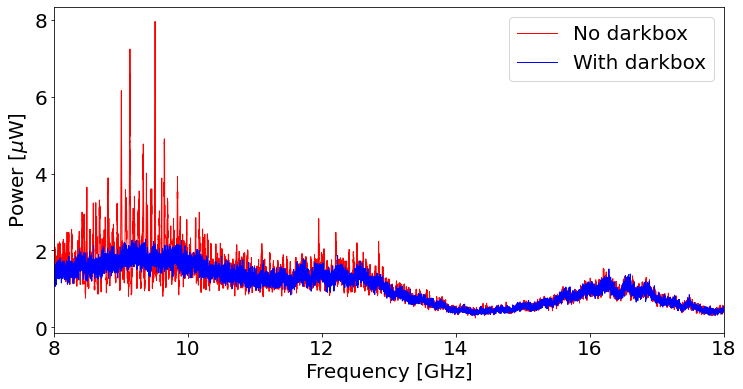

In [14]:
fig = plt.figure(figsize=(12,6))
plt.plot(freq_1, power_1*1e+3, label=f'{label_1}', color='red', marker='', markersize=0.5, linestyle='-', linewidth=1)
plt.plot(freq_2, power_2*1e+3, label=f'{label_2}', color='blue', marker='', markersize=0.5, linestyle='-', linewidth=1)
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel(r'Power [$\mu$W]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定

plt.legend()

plt.savefig(f'{outdir}/compare_power_W.png')
plt.show()

###  Plot Power [W] for slide (10--18 GHz)

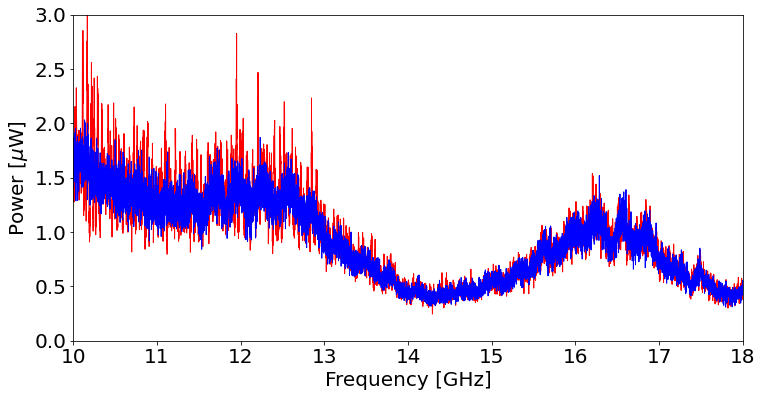

In [15]:
fig = plt.figure(figsize=(12,6))
plt.plot(freq_1, power_1*1e+3, label=f'{label_1}', color='red', marker='', markersize=0.5, linestyle='-', linewidth=1)
plt.plot(freq_2, power_2*1e+3, label=f'{label_2}', color='blue', marker='', markersize=0.5, linestyle='-', linewidth=1)
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel(r'Power [$\mu$W]') #y軸の名前
#plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(0, 8.) #y軸範囲指定

plt.xlim(10,18) #x軸範囲指定
plt.ylim(0,3.) #y軸範囲指定

#plt.legend()

plt.savefig(f'{outdir}/compare_power_W_10-18GHz.png')
plt.show()

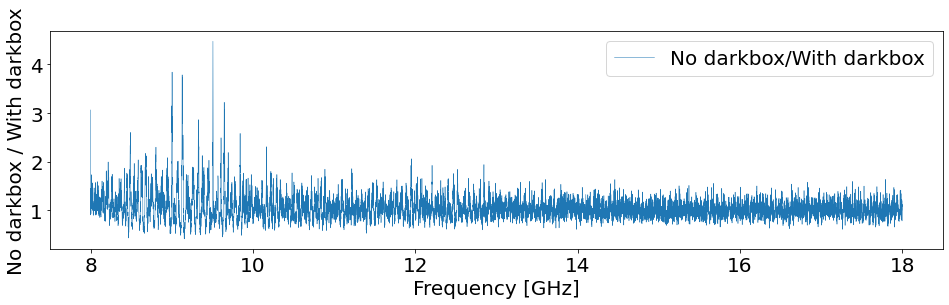

In [9]:
power_2_interp = freq_interpolate(freq_1, freq_2, power_2)
div_power = power_1/power_2_interp

fig = plt.figure(figsize=(16,4))
plt.plot(freq_1, div_power, label=f'{label_1}/{label_2}', color='tab:blue', marker='', markersize=0.5, linestyle='-', linewidth=0.5)
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel(f'{label_1} / {label_2}') #y軸の名前
#plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定

plt.legend()

plt.savefig(f'{outdir}/compare_power_div.png')
plt.show()

###  Plot Power [dBm]

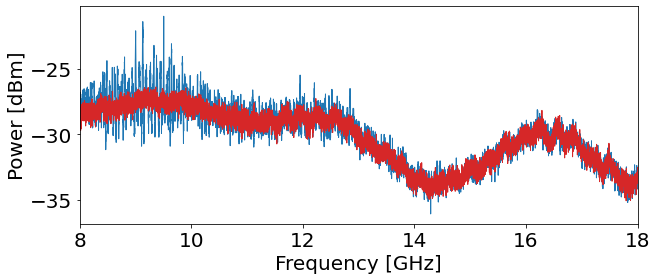

In [10]:
power_1_dBm = np.log10(power_1)*10.
power_2_dBm = np.log10(power_2)*10.


#fig = plt.figure(figsize=(16,4))
fig = plt.figure(figsize=(10,4))
plt.plot(freq_1, power_1_dBm, label=f'{label_1}', color='tab:blue', marker='', markersize=0.5, linestyle='-', linewidth=1)
plt.plot(freq_2, power_2_dBm, label=f'{label_2}', color='tab:red', marker='', markersize=0.5, linestyle='-', linewidth=1)
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [dBm]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(-35,-20) #y軸範囲指定
#plt.legend(frameone='off')

plt.savefig(f'{outdir}/compare_power_dBm.png')
plt.show()

### Plot averaged power

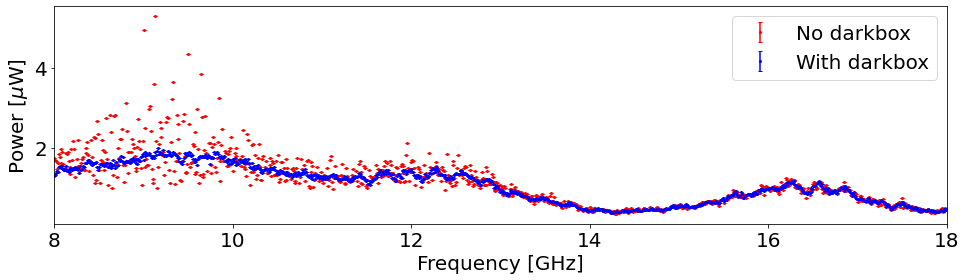

In [21]:
nAve = 10
fig = plt.figure(figsize=(16,4))
freq_ave_1, tmp = freq_average(freq_1, naverage=nAve)
freq_ave_2, tmp = freq_average(freq_2, naverage=nAve)
power_1_ave, power_1_ave_err = freq_average(power_1, naverage=nAve)
power_2_ave, power_2_ave_err = freq_average(power_2, naverage=nAve)
plt.errorbar(freq_ave_1, power_1_ave*1e+3, yerr=power_1_ave_err, label=f'{label_1}', capsize=2, fmt='o', markersize=2, ecolor='red', markeredgecolor = "red", color='red')
plt.errorbar(freq_ave_2, power_2_ave*1e+3, yerr=power_2_ave_err, label=f'{label_2}', capsize=2, fmt='o', markersize=2, ecolor='blue', markeredgecolor = "blue", color='blue')

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel(r'Power [$\mu$W]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
plt.legend()

plt.savefig(f"{outdir}/compare_power_average.png")
plt.show()

###  Plot averaged power [W] for slide (10--18 GHz)

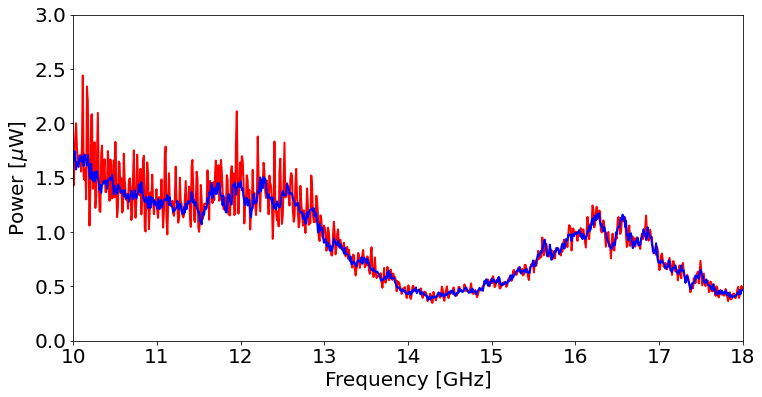

In [24]:
nAve = 10
fig = plt.figure(figsize=(12,6))
freq_ave_1, tmp = freq_average(freq_1, naverage=nAve)
freq_ave_2, tmp = freq_average(freq_2, naverage=nAve)
power_1_ave, power_1_ave_err = freq_average(power_1, naverage=nAve)
power_2_ave, power_2_ave_err = freq_average(power_2, naverage=nAve)
plt.plot(freq_ave_1, power_1_ave*1e+3, label=f'{label_1}', markersize=1, color='red' , lw=2)
plt.plot(freq_ave_2, power_2_ave*1e+3, label=f'{label_2}', markersize=1, color='blue', lw=2)

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel(r'Power [$\mu$W]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
plt.xlim(10,18) #x軸範囲指定
plt.ylim(0,3) #y軸範囲指定

plt.savefig(f"{outdir}/compare_power_average_10-18GHz.png")
plt.show()

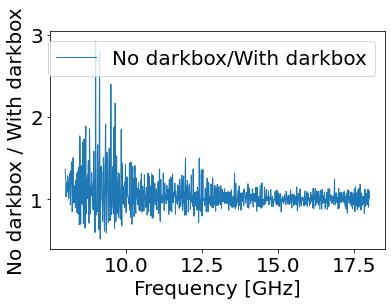

In [12]:
power_2_ave_interp = freq_interpolate(freq_ave_1, freq_ave_2, power_2_ave)
div_power_ave = power_1_ave/power_2_ave_interp

plt.plot(freq_ave_1, div_power_ave, label=f'{label_1}/{label_2}', color='tab:blue', marker='', markersize=0.5, linestyle='-', linewidth=1.0)
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel(f'{label_1} / {label_2}') #y軸の名前
#plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定

plt.legend()

plt.savefig(f'{outdir}/compare_power-ave_div.png')
plt.show()